Julia

Comenzaremos usando Julia y lo primero que haremos será importar los paquetes necesarios para que funcione el programa.

In [ ]:
import Pkg;
Pkg.add("DeconvOptim")
Pkg.add("TestImages")
Pkg.add("Colors")
Pkg.add("ImageIO")
Pkg.add("Noise")
Pkg.add("ImageShow")
Pkg.add("Images")
Pkg.add("FFTW")
Pkg.add("Plots")
Pkg.add("BenchmarkTools")

Una vez importados los paquetes lo que hemos hecho ha sido coger una imagen de prueba, añadirla borrosidad y ruido y hacer la deconvolución en 2D sin regularizar.
Usaremos la misma PSF para el código en python y el mismo número de iteraciones.

  599.489 ms (5827 allocations: 172.58 MiB)


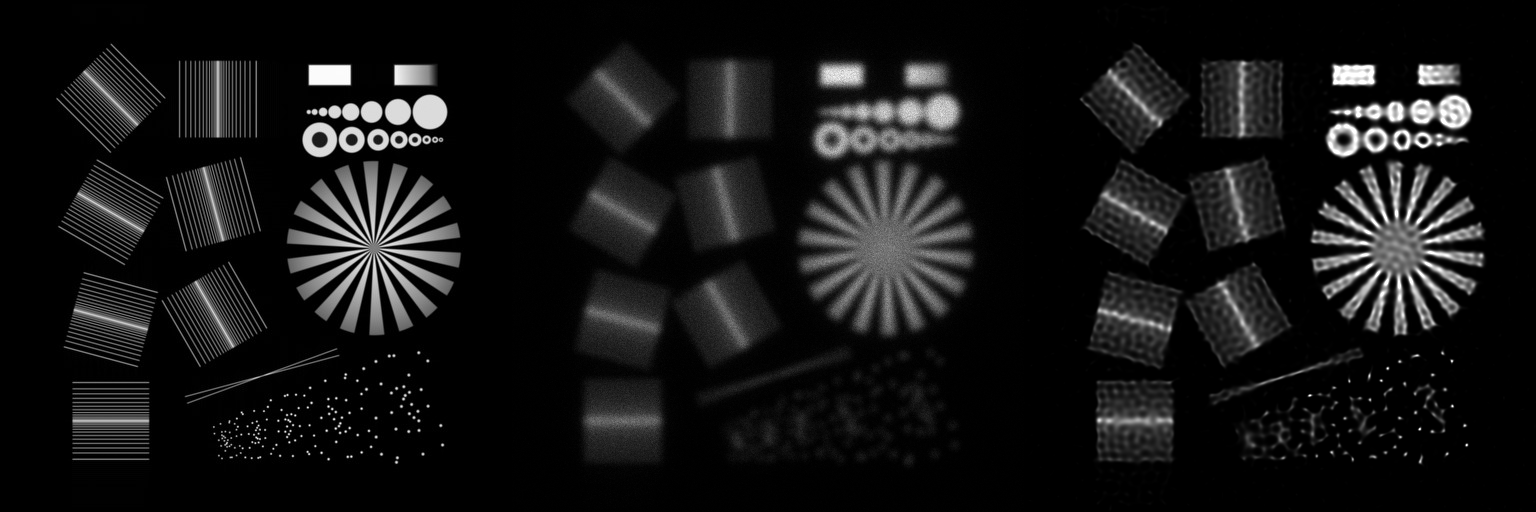

In [135]:
using DeconvOptim, TestImages, Colors, ImageIO, Noise, ImageShow, Images, Plots, BenchmarkTools

# load test image

img = load("ImagenPrueba.jpg")
img = Float32.(img)

psf = Float32.(generate_psf(size(img), 30))


# create a blurred, noisy version of that image
img_b = conv(img, psf) #blurred
img_n = poisson(img_b, 300) #blurred and noisy

save("blurrednoisy_img.jpg", img_b)

# deconvolve 2D with default options
# @time res, o = deconvolution(img_n, psf)

# deconvolve 2D with no regularizer
res_no_reg, o = deconvolution(img_n, psf, regularizer=nothing, iterations=30)
@btime res_no_reg, o = deconvolution(img_n, psf, regularizer=nothing, iterations=30)
# show final results next to original and blurred version
Gray.([img img_n res_no_reg])


ifftshift: Es una función utilizada en el contexto de transformadas de Fourier inversas (inversa de la Transformada de Fourier Discreta, DFT por sus siglas en inglés). Esta función reordena los elementos de un array de manera que el centro del arreglo (frecuencia cero) se desplace al inicio del array. Esto es crucial para asegurar que al realizar la inversa de una DFT, el resultado esté centrado de manera adecuada.

En nuestro caso la función de Julia generate_psf() genera una PSF la cual quedan las diagonales intercambiadas, si queremos guardar la PSF centrada tenemos que usar la función ifftshift

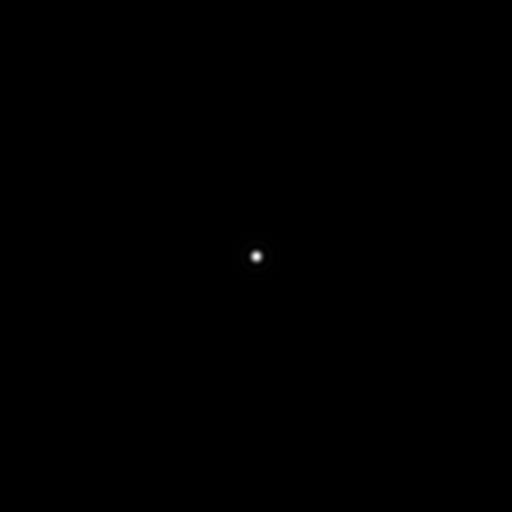

In [136]:
using FFTW

# Normalize the PSF values to the range [0, 1]
psf_min = minimum(psf)
psf_max = maximum(psf)
psf_normalized = (psf .- psf_min) ./ (psf_max - psf_min)
# Save the normalized PSF as a JPEG image
psf_gray = Gray.(psf_normalized)

#If you want to provide your PSF model, ensure that centered around the first entry of the array (psf[1]). 
#You may need to use ifftshift for a PSF model or a measured PSF.

centered_psf = ifftshift(psf_normalized)
centered_psf = Gray.(centered_psf)

# Save the PSF as a JPEG image
save("psf.jpg", centered_psf)
display(centered_psf)


Ahora vamos a usar la función richardson_lucy_iterative del módulo deconvoptim.jl sin regularización.

  124.344 ms (33 allocations: 7.01 MiB)


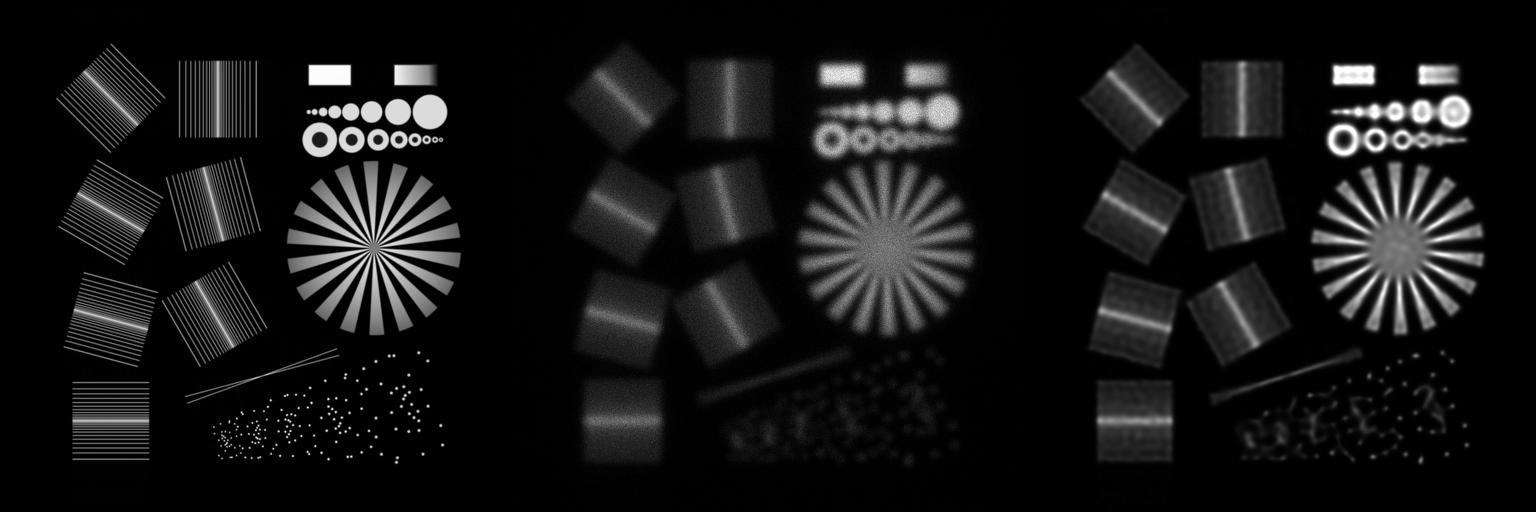

In [137]:
restored_img = richardson_lucy_iterative(img_n, psf; regularizer=nothing, iterations=30)
@btime restored_img = richardson_lucy_iterative(img_n, psf; regularizer=nothing, iterations=30)
Gray.([img img_n restored_img])

Veremos ahora ejemplos con TV regularization en Julia

  666.963 ms (633979 allocations: 66.57 MiB)


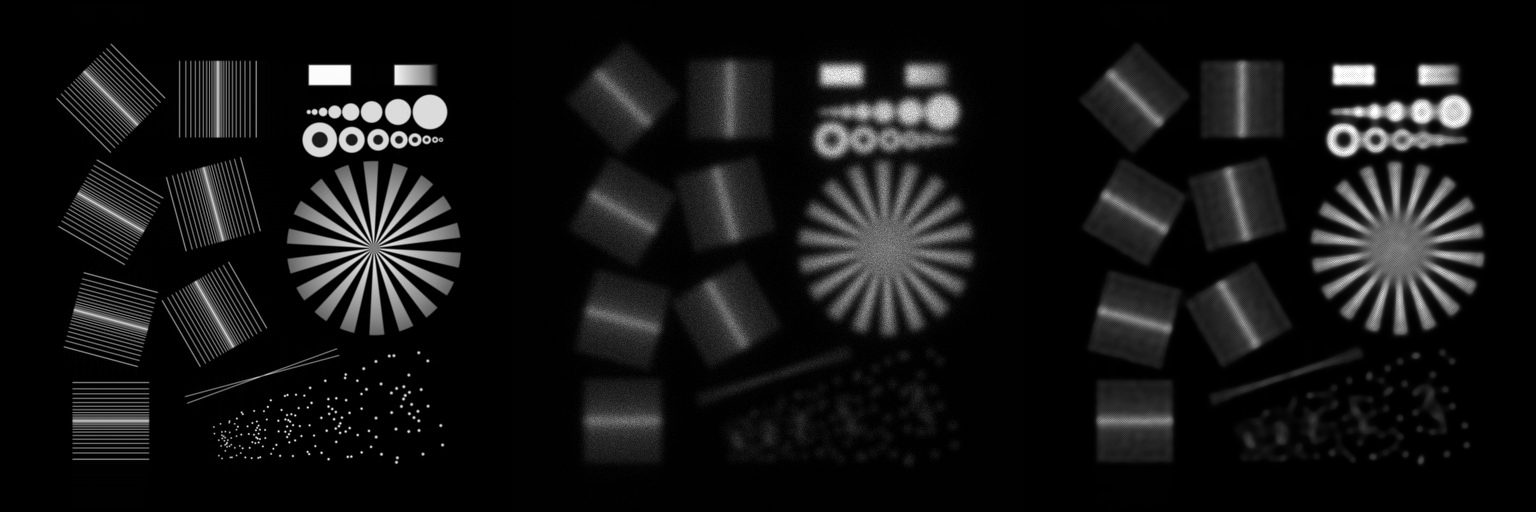

In [138]:
optim_res = richardson_lucy_iterative(img_n, psf, λ=0.05, regularizer=TV(), iterations=20)
@btime optim_res = richardson_lucy_iterative(img_n, psf, λ=0.05, regularizer=TV(), iterations=20)
Gray.([img img_n optim_res])

Python

In [ ]:
pip install numpy matplotlib scipy scikit-image imageio

3.08 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


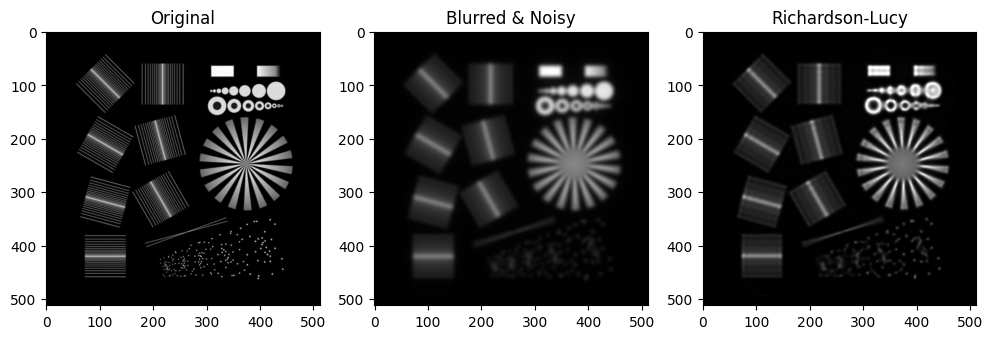

7.181519269943237


In [1]:
import numpy as np
from skimage import img_as_float
from skimage.restoration import richardson_lucy
import matplotlib.pyplot as plt
import imageio.v2 as iio
import time

inicio = time.time()

# Load test image
img = img_as_float(iio.imread("ImagenPrueba.jpg"))

# Cargamos la imagen borrosa y con ruido de Julia y la psf

psf = img_as_float(iio.imread("psf.jpg"))
img_n = img_as_float(iio.imread("blurrednoisy_img.jpg"))

%timeit -n 1 -r 1 richardson_lucy(img_n, psf, num_iter=30)

# Deconvolve the image using Richardson-Lucy algorithm
res = richardson_lucy(img_n, psf, num_iter=30)

# Display original, blurred, and deconvolved images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(img_n, cmap='gray')
plt.title('Blurred & Noisy')

plt.subplot(1, 3, 3)
plt.imshow(res, cmap='gray')
plt.title('Richardson-Lucy')

plt.show()

fin = time.time()
print(fin-inicio)

INTENTO de ejemplos con TV regularization en Python

La función richardson_lucy del módulo skimage.restoration, esta función no tiene un argumento regularizer para especificar una función de regularización personalizada.
Para utilizar una función de regularización personalizada, tendrías que implementar el algoritmo de Richardson-Lucy por tu cuenta, ya que la función proporcionada en scikit-image no admite directamente la regularización de variación total (TV) como en Julia.

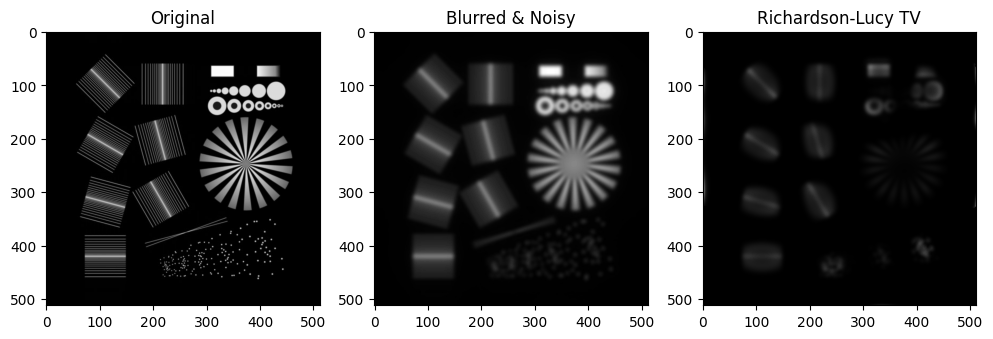

63.84981393814087


In [18]:

inicio = time.time()

# Función de deconvolución de Richardson-Lucy con regularización de TV
def richardson_lucy_tv(image, psf, iterations, lambda_):
    restored_img = np.copy(image)
    for _ in range(iterations):
        estimate = richardson_lucy(restored_img, psf, num_iter=1)
        regularized_estimate = denoise_tv_chambolle(estimate, weight=(1/lambda_)) #weight=1/lambda
        restored_img *= regularized_estimate / (richardson_lucy(estimate, psf, num_iter=1) + 1e-8) #1e-8 se suma para evitar divisiones por cero en el caso de que el denominador sea muy pequeño
    return restored_img

# denoise_tv_bregman tarda mucho menos pero el resultado es parecido weight=lambda/2
def generate_psf(shape, radius):
    y, x = np.mgrid[-radius:radius+1, -radius:radius+1]
    psf = np.exp(-(x**2 + y**2)/(2.0*radius**2))
    return psf / np.sum(psf)

psf1 = generate_psf(img.shape, 30)
img_n1 = img_as_float(iio.imread("blurrednoisy_img.jpg"))

optim_res_py = richardson_lucy_tv(img_n, psf, iterations=20, lambda_=0.05)
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(img_n1, cmap='gray')
plt.title('Blurred & Noisy')

plt.subplot(1, 3, 3)
plt.imshow(optim_res_py, cmap='gray')
plt.title('Richardson-Lucy TV')

plt.show()

fin = time.time()
print(fin-inicio)